In [199]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

file_path = "F:\\All data\\Patient_Signal\\PPG.csv"
data = pd.read_csv(file_path, header=None)

data.columns = ['Name', 'i', 'Bad', 'hands', 'label', 'systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI', 'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle', '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA', 'Ratio_BDCE_A', 'Ratio_CDB_A']
# Display the first few rows of the dataframe to understand its structure
data.head()

,Name,i,Bad,hands,label,systolic peak,Diastolic peak,Cardiac cycle,Cycle Area,SSI,Peak to Valley,Systolic peak y,Delta_T,1st Derivative cycle,1st Derivative peak,Ratio_BA,Ratio_CA,Ratio_DA,Ratio_BDCE_A,Ratio_CDB_A
0,伍黃秀霞,1,Right,Left,1,1278.0,0.390019,993.0,315.004855,987.0,720.0,0.516570,-1277.609981,1000.0,0.447513,1.022991,1.029483,1.047664,-2.109080,1.022221
1,伍黃秀霞,1,Right,Right,1,1265.0,0.275706,977.0,267.261331,995.0,714.0,0.485722,-1264.724294,994.0,0.327676,0.999176,0.997674,0.993834,-1.982910,1.000930
2,伍黃秀霞,3,Right,Left,1,1280.0,0.344179,997.0,307.701319,1011.0,718.0,0.468073,-1279.655821,994.0,0.427002,1.027341,1.050224,1.074771,-2.195227,1.027423
3,伍黃秀霞,3,Right,Right,1,1278.0,0.350065,979.0,286.925793,1011.0,705.0,0.506998,-1277.649935,1005.0,0.343972,0.991613,0.974413,0.961078,-1.887815,0.991555
4,伍黃秀霞,5,Right,Left,1,1296.0,0.354134,1000.0,318.004937,1009.0,701.0,0.428415,-1295.645866,996.0,0.360314,1.029600,1.045462,1.071122,-2.174579,1.028988


In [200]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns[0])

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

systolic peak


In [201]:
# 繪製混淆矩陣
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5), dpi=120)
    plt.imshow(conf_matrix, cmap='summer')
    plt.colorbar()

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), fontsize=12,
                     horizontalalignment='center', verticalalignment='center')


    
    plt.xticks(np.arange(0, 2), ['Predicted 0', 'Predicted 1'])
    plt.yticks(np.arange(0, 2), ['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

In [202]:
# 計算性能指標
def calculate_metrics(conf_matrix):
    tp = conf_matrix[0, 0]
    fn = conf_matrix[0, 1]
    fp = conf_matrix[1, 0]
    tn = conf_matrix[1, 1]
    accuracy = (tp + tn) / (tp + fn + fp + tn) if (tp + fn + fp + tn) != 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

    metrics = {
        "Accuracy": round(accuracy,3),
        "Sensitivity (Recall)": round(sensitivity,3),
        "Specificity": round(specificity,3),
        "Precision": round(precision,3),
        "F1-Score": round(f1_score,3)
    }
    return metrics

In [203]:
# 儲存結果到 CSV
def save_results_to_csv(filename, info, y_test, y_pred):
    new_data = pd.DataFrame({
        'Name': info['Name'].values,
        'Cycle': info['i'].values,
        'Hands': info['hands'].values,
        'Actual_Label': y_test.values,
        'Predicted_Label': y_pred
    })

    new_data = new_data.sort_values(by='Name')
    new_data['Is_Correct'] = new_data['Actual_Label'] == new_data['Predicted_Label']
    new_data.to_csv(f"F:\\All data\\Patient_Signal\\{filename}.csv", index=False, encoding='utf-8-sig')
    print(f"Results saved to {filename}.csv")

    # 將最終的 Actual_Label 和 Predicted_Label 的總結結果保存
    final_summary = new_data.groupby('Name').agg(
    Actual_0_Count=('Actual_Label', lambda x: (x == 0).sum()),
    Actual_1_Count=('Actual_Label', lambda x: (x == 1).sum()),
    Predicted_0_Count=('Predicted_Label', lambda x: (x == 0).sum()),
    Predicted_1_Count=('Predicted_Label', lambda x: (x == 1).sum())
    ).reset_index()

    # 判斷總體的預測結果
    final_summary['Predicted_Label'] = final_summary.apply(lambda row: 0 if row['Predicted_0_Count'] > row['Predicted_1_Count'] else 1, axis=1)
    final_summary['Actual_Label'] = final_summary.apply(lambda row: 0 if row['Actual_0_Count'] > row['Actual_1_Count'] else 1, axis=1)

    # 保存總結至 CSV
    final_summary.to_csv(f"F:\\All data\\Patient_Signal\\{filename}_Final.csv", index=False, encoding='utf-8-sig')
    print(f"Results saved to {filename}_Final.csv")

    
    conf_matrix = confusion_matrix(final_summary['Actual_Label'], final_summary['Predicted_Label'])
    plot_confusion_matrix(conf_matrix, title='Final Confusion Matrix')
    metrics = calculate_metrics(conf_matrix)
    print("Final Metrics:", metrics)
    

Fitting 5 folds for each of 4 candidates, totalling 20 fits
最佳參數: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
特徵重要性排序：
                  Feature  Importance
14           Ratio_CDB_A    1.586266
13          Ratio_BDCE_A    1.421487
10              Ratio_BA    1.359818
12              Ratio_DA    1.134057
9    1st Derivative peak    1.056132
3             Cycle Area    0.990431
6        Systolic peak y    0.568145
11              Ratio_CA    0.341283
0          systolic peak    0.246978
7                Delta_T    0.246856
4                    SSI    0.227613
1         Diastolic peak    0.131110
2          Cardiac cycle    0.122146
5         Peak to Valley    0.089581
8   1st Derivative cycle    0.084869


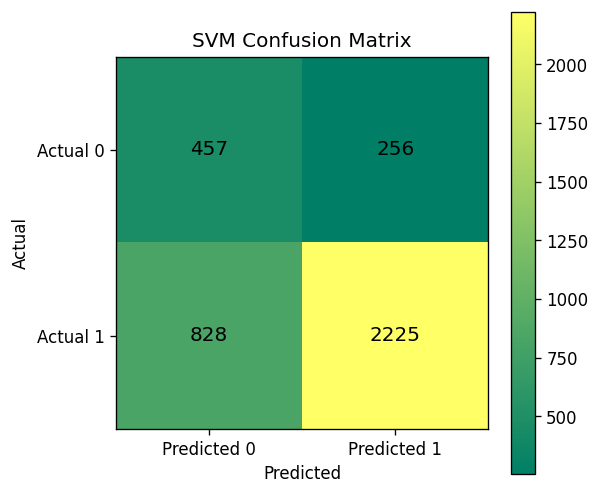

SVM Metrics: {'Accuracy': 0.712, 'Sensitivity (Recall)': 0.641, 'Specificity': 0.729, 'Precision': 0.356, 'F1-Score': 0.457}
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv


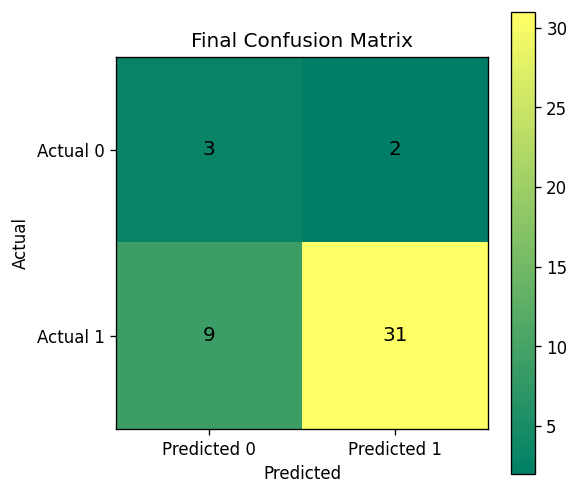

Final Metrics: {'Accuracy': 0.756, 'Sensitivity (Recall)': 0.6, 'Specificity': 0.775, 'Precision': 0.25, 'F1-Score': 0.353}


In [204]:
# 定義 SVM 模型
def train_svm(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear'],
        'class_weight': ['balanced']
    }

    svm_grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    svm_grid_search.fit(X_train, y_train)

    best_model = svm_grid_search.best_estimator_
    best_params = svm_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    feature_importance = np.abs(best_model.coef_[0])
    feature_importance_df = pd.DataFrame({
        'Feature': X_columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

        # 預測測試集

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred, feature_importance_df


# SVM
svm_model, svm_metrics, svm_conf_matrix, svm_y_pred, feature_importance_df = train_svm(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(svm_conf_matrix, title='SVM Confusion Matrix')
print("SVM Metrics:", svm_metrics)
save_results_to_csv('SVM_Results', info_test, y_test, svm_y_pred)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
特徵重要性排序：
                  Feature  Importance
0          systolic peak    0.195053
7                Delta_T    0.194911
1         Diastolic peak    0.119947
9    1st Derivative peak    0.076205
5         Peak to Valley    0.053089
3             Cycle Area    0.052094
8   1st Derivative cycle    0.026143
6        Systolic peak y    0.024375
12              Ratio_DA    0.020650
4                    SSI    0.020474
13          Ratio_BDCE_A    0.019994
2          Cardiac cycle    0.019480
11              Ratio_CA    0.011711
10              Ratio_BA    0.005287
14           Ratio_CDB_A    0.004940


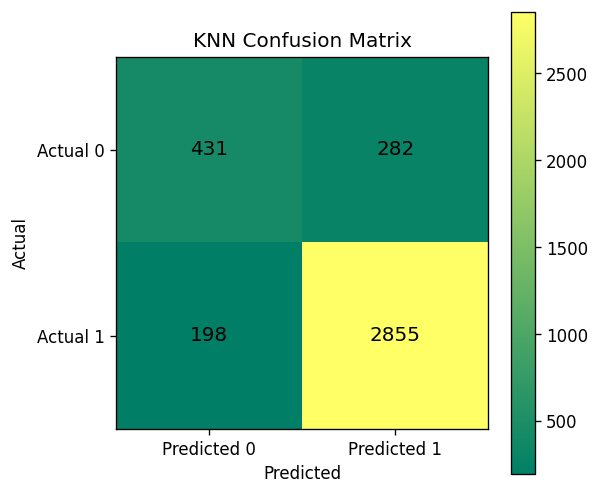

KNN Metrics: {'Accuracy': 0.873, 'Sensitivity (Recall)': 0.604, 'Specificity': 0.935, 'Precision': 0.685, 'F1-Score': 0.642}
Results saved to KNN_Results.csv
Results saved to KNN_Results_Final.csv


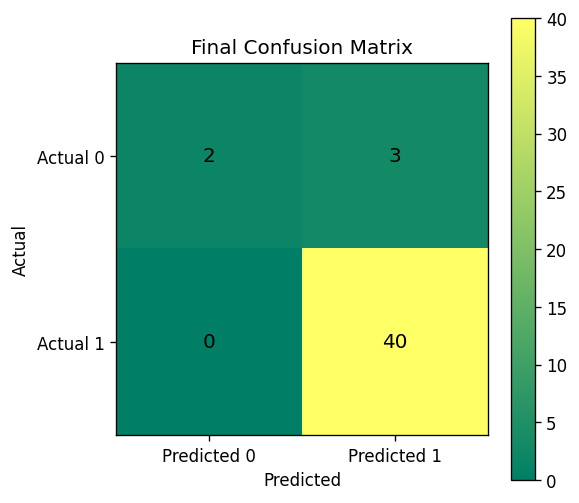

Final Metrics: {'Accuracy': 0.933, 'Sensitivity (Recall)': 0.4, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.571}


In [205]:
# 定義 KNN 模型
def train_knn(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    knn_grid_search.fit(X_train, y_train)

    best_model = knn_grid_search.best_estimator_
    best_params = knn_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    # 特徵重要性 - 基於相關性分析（例如皮爾森相關係數）
    feature_importance = np.abs(np.corrcoef(X_train.T, y_train.values, rowvar=True)[:-1, -1])
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

        # 預測測試集

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred

# KNN
knn_model, knn_metrics, knn_conf_matrix, knn_y_pred = train_knn(X_train, y_train, X_test, y_test)
plot_confusion_matrix(knn_conf_matrix, title='KNN Confusion Matrix')
print("KNN Metrics:", knn_metrics)
save_results_to_csv('KNN_Results', info_test, y_test, knn_y_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
特徵重要性排序：
                  Feature  Importance
7                Delta_T    0.098509
3             Cycle Area    0.097309
0          systolic peak    0.081020
9    1st Derivative peak    0.077572
1         Diastolic peak    0.075840
10              Ratio_BA    0.075336
14           Ratio_CDB_A    0.061959
12              Ratio_DA    0.058728
5         Peak to Valley    0.058585
13          Ratio_BDCE_A    0.057341
4                    SSI    0.056870
11              Ratio_CA    0.054248
6        Systolic peak y    0.051800
8   1st Derivative cycle    0.051004
2          Cardiac cycle    0.043879


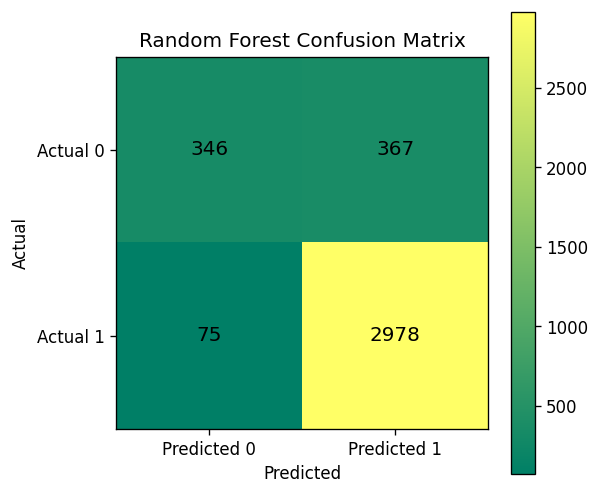

Random Forest Metrics: {'Accuracy': 0.883, 'Sensitivity (Recall)': 0.485, 'Specificity': 0.975, 'Precision': 0.822, 'F1-Score': 0.61}
Results saved to RF_Results.csv
Results saved to RF_Results_Final.csv


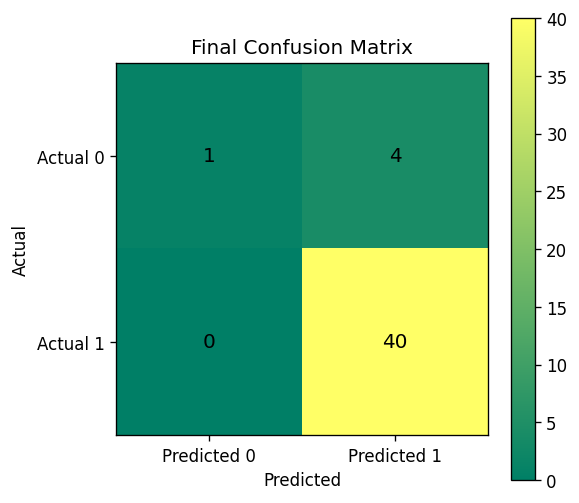

Final Metrics: {'Accuracy': 0.911, 'Sensitivity (Recall)': 0.2, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.333}


In [206]:
# 定義 Random Forest 模型
def train_rf(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    }

    rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    rf_grid_search.fit(X_train, y_train)

    best_model = rf_grid_search.best_estimator_
    best_params = rf_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

        # 特徵重要性 - Random Forest 原生支援
    feature_importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)
    
    return best_model, metrics, conf_matrix, y_pred

# Random Forest
rf_model, rf_metrics, rf_conf_matrix, rf_y_pred = train_rf(X_train, y_train, X_test, y_test)
plot_confusion_matrix(rf_conf_matrix, title='Random Forest Confusion Matrix')
print("Random Forest Metrics:", rf_metrics)
save_results_to_csv('RF_Results', info_test, y_test, rf_y_pred)
# 輸出結果
